<a href="https://colab.research.google.com/github/ManikantaMandlem/Deep-Q-Network-to-play-2048-Game/blob/main/DRL_Final_Project_tiny_2048.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

change reward policy - max tile - not working
reward policy - max tile at corners - check
reward policy - tiles with big numbers to the adjacent - check
reward policy - step by step rewarding policy - figure out

In [ ]:
!pip install gym-2048

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.8 MB/s 
     |████████████████████████████████| 13.8 MB 42.6 MB/s 
  Created wheel for gym-2048: filename=gym_2048-0.2.6-py3-none-any.whl size=4697 sha256=79fdd0afd5afa607109f2f7828c0c0dc2dd8ab84bdb33d0c5dd9ab6a92072042
  Stored in directory: /root/.cache/pip/wheels/68/98/9f/c396b6407bd4c0906c2a6ed5905202cd0d423dd2d6d8db05a2
  Created wheel for gym: filename=gym-0.10.11-py3-none-any.whl size=1588313 sha256=e3bc3a54ae6a041bbc12847cfc757e90ee248826e0f8c9a8364e967e85575afb
  Stored in directory: /root/.cache/pip/wheels/ec/c9/3a/068c5b80305e89c8de8b0a412e67ef2986cbad74895cfb9551
Successfully built gym-2048 gym
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstallin

In [ ]:
print(torch.__version__)

1.11.0+cu113


In [ ]:
import gym_2048
import gym
import torch.nn as nn
import torch
from collections import deque
import numpy as np
from datetime import datetime
from random import sample
import matplotlib.pyplot as plt
import time
import math

In [ ]:
#defining a neural network class for network initializations

class torch_model(nn.Module):
    def __init__(self,layers,dropout=0,normalization=False,hidden_activation='relu'):
        super(torch_model,self).__init__()
        self.layers = layers
        self.dropout = dropout
        self.normalization = normalization
        self.hidden_activation = hidden_activation

        #defining different layers
        self.nn_layers = []
        for i in range(len(self.layers)-2):
            self.nn_layers.append(nn.Linear(self.layers[i],self.layers[i+1]))
            if hidden_activation == 'relu':
                self.nn_layers.append(nn.ReLU())
            elif hidden_activation == 'sigmoid':
                self.nn_layers.append(nn.Sigmoid())
            elif hidden_activation == 'silu':
                self.nn_layers.append(nn.SiLU())
            elif hidden_activation == 'tanh':
                self.nn_layers.append(nn.Tanh())
            elif hidden_activation == 'celu':
                self.nn_layers.append(nn.CELU())
            else:
                raise Exception('activation function not recognized; available options are relu, sigmoid, silu, tanh, celu')
            if normalization:
                self.nn_layers.append(nn.BatchNorm1d(self.layers[i+1]))
            self.nn_layers.append(nn.Dropout(self.dropout))
        self.nn_layers.append(nn.Linear(self.layers[-2],self.layers[-1]))
        self.nn_layers = nn.ModuleList(self.nn_layers)
    def forward(self,x):
        for layer in self.nn_layers:
            x = layer(x)
        return x

In [ ]:
def print_model(model):
    """ 
    A simple functon that prints out a PyTorch model's structural details

    PARAMETERS
    ----------
    model     a torch.nn.Model
    """

    # Print model's state_dict
    print("Model's state dictionary (stored weights):")
    for param_tensor in model.state_dict():
        print("  ", param_tensor, "\t", tuple(model.state_dict()[param_tensor].size()))

    # Print the number of parameters in the model    
    parameter_count =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("In total, this network has ", parameter_count, " trainable parameters")

In [ ]:
class rl_agent():
    def __init__(self,kwargs):
        self.environment = gym.make('Tiny2048-v0')
        self.state_size = self.environment.observation_space.shape[0]*self.environment.observation_space.shape[1]
        self.action_size = self.environment.action_space.n
        self.episodes = kwargs['episodes']
        self.memory = deque(maxlen=kwargs['memory_len'])
        self.gamma = kwargs['gamma']    # discount rate
        self.epsilon = kwargs['epsilon_start']  # exploration rate
        self.epsilon_min = kwargs['epsilon_min']
        self.epsilon_decay = kwargs['epsilon_decay']
        self.batch_size = kwargs['batch_size']
        self.train_start = kwargs['train_start']
        self.model = torch_model(layers=kwargs['layers'],dropout=kwargs['dropout'],
                                 normalization=kwargs['batch_norm'],hidden_activation=kwargs['activation'])
        # print_model(self.model)
        #defining memory to remember states, next_states, rewards, actions
        self.memory = deque(maxlen = 10000)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=kwargs['lr'])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start and self.epsilon > self.epsilon_min:
            # print('epsilon updated')
            self.epsilon *= self.epsilon_decay
    def reward_strategy(self,state,score):
        # reward = score
        #bottom left corner should have the maximum tile
        return torch.sum(state)

        
    #training the neural network to approximate the q function
    def replay(self):
        if len(self.memory) < self.train_start: #if enough examples are not present, then do not train the neural network
            # print('model is not training')
            return
        # Randomly sample minibatch from the memory
        minibatch = sample(self.memory, self.batch_size)
        state = torch.zeros((self.batch_size, self.state_size))
        next_state = torch.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []
        # assign data into state, next_state, action, reward and done from minibatch
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            next_state[i] = minibatch[i][3]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            done.append(minibatch[i][4])
        # compute value function of current(call it target) and value function of next state(call it target_next)
        self.model.train()
        q_target = self.model(state)
        q_target_next = self.model(next_state)
        for i in range(self.batch_size):
            # correction on the Q value for the action used,
            # if done[i] is true, then the target should be just the final reward
            if done[i]:
                q_target[i][action[i]] = reward[i]
            else:
                q_target[i][action[i]] = reward[i] + self.gamma * torch.max(q_target_next[i])
        # Train the Neural Network with batches where target is the value function
        # print('model is training')
        self.optimizer.zero_grad()
        q_values = self.model(state)
        loss = self.loss_fn(q_values,q_target)
        loss.backward()
        self.optimizer.step()


    def training(self):
        runs_array = []
        for episode in range(self.episodes):
            run = 0
            state = torch.from_numpy(self.environment.reset()) #resetting the game environment and capturing the first state of the game
            state = torch.reshape(state,(1,self.state_size))
            state = state.float()
            # print(state)
            # print(type(state))
            # print(state.shape)
            done = False
            # acc_reward = 0
            while not done: #untill the game is not over, play the game
                #take the epsilon greedy action
                # with torch.no_grad():
                # self.environment.render()
                # time.sleep(5)
                run += 1
                self.model.eval()
                q_values = self.model(state)
                greedy_action = torch.argmax(q_values).item()
                random_action = np.random.choice([0,1,2,3])
                final_action = np.random.choice([greedy_action,random_action],p=[1-self.epsilon,self.epsilon])
                #run the selected action and get the next state, reward, done

                next_state, score, done, _ = self.environment.step(final_action)
                next_state = torch.from_numpy(next_state.copy())
                next_state = next_state.float()
                #may need to change and test other rewarding methods like max(tiles), difference between max tile and 2048 etc
                # acc_reward += reward
                if done and torch.max(next_state)!= 2048:
                    reward = -100
                else:
                    reward = self.reward_strategy(next_state,score) #should we consider state --> next_state in the reward strategy?
                #storing the state-action-nextstate-reward-done touple in memory for training purpose
                next_state = torch.reshape(next_state, (1, self.state_size))
                self.remember(state, final_action, reward, next_state, done)
                #updating the state to next_state
                state = next_state
                if done:
                    self.environment.render()
                    #return_rewards.append(i)
                    dateTimeObj = datetime.now()
                    timestampStr = dateTimeObj.strftime("%H:%M:%S")
                    print("episode: {}/{}, score: {}, max_tile: {},e: {:.2}, runs: {}".format(episode+1, self.episodes, reward, torch.max(state),self.epsilon, run))
                    # save model option
                    # if i >= 500:
                    #     print("Saving trained model as cartpole-dqn-training.h5")
                    #     self.save("./save/cartpole-dqn-training.h5")
                    #     return # remark this line if you want to train the model longer
                self.replay()
            runs_array.append(run)
        return runs_array

        

In [ ]:
kwargs = {
    'episodes':700,
    'gamma':0.95,
    'epsilon_start':1.0,
    'epsilon_min':0.000001,
    'epsilon_decay':0.999,
    'batch_size':64,
    'train_start':200,
    'layers':[4,2048,1024,512,256,128,64,32,4],
    'dropout':0.0,
    'batch_norm':False,
    'activation':'relu',
    'lr':0.0001,
    'memory_len':50000
}

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


2 	8
4 	2
episode: 1/700, score: -100, max_tile: 8.0,e: 1.0, runs: 7
8 	4
16 	2
episode: 2/700, score: -100, max_tile: 16.0,e: 1.0, runs: 15
8 	2
2 	4
episode: 3/700, score: -100, max_tile: 8.0,e: 1.0, runs: 5
2 	16
8 	2
episode: 4/700, score: -100, max_tile: 16.0,e: 1.0, runs: 18
4 	8
2 	4
episode: 5/700, score: -100, max_tile: 8.0,e: 1.0, runs: 6
2 	4
8 	2
episode: 6/700, score: -100, max_tile: 8.0,e: 1.0, runs: 5
4 	8
2 	4
episode: 7/700, score: -100, max_tile: 8.0,e: 1.0, runs: 9
4 	2
2 	4
episode: 8/700, score: -100, max_tile: 4.0,e: 1.0, runs: 5
4 	2
2 	4
episode: 9/700, score: -100, max_tile: 4.0,e: 1.0, runs: 5
16 	2
2 	4
episode: 10/700, score: -100, max_tile: 16.0,e: 1.0, runs: 12
4 	8
2 	4
episode: 11/700, score: -100, max_tile: 8.0,e: 1.0, runs: 5
8 	2
2 	8
episode: 12/700, score: -100, max_tile: 8.0,e: 1.0, runs: 8
2 	4
4 	2
episode: 13/700, score: -100, max_tile: 4.0,e: 1.0, runs: 4
8 	2
2 	8
episode: 14/700, score: -100, max_tile: 8.0,e: 1.0, runs: 10
8 	2
2 	4
episode: 

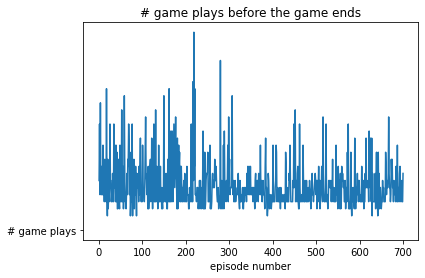

In [ ]:
if __name__ == "__main__":
    # rewards_final = []
    # runs = 20
    # for run in range(runs):
    agent = rl_agent(kwargs)
    runs = agent.training()
    plt.plot(range(1,701),runs)
    plt.title('# game plays before the game ends')
    plt.xlabel('episode number')
    plt.plot('# game plays')
    plt.show()
        # rewards_final.append(agent.training())
    # rewards_final  =np.array(rewards_final)
    # rewards_avg = np.average(rewards_final,axis = 0)
    # rewards_std = np.std(rewards_final,axis = 0)
    # plt.plot(list(range(1,151)),rewards_avg,color = 'red',label='average')
    # plt.fill_between(list(range(1,151)),rewards_avg-rewards_std,rewards_avg+rewards_std,color='red',label='+/- 1 std',alpha=0.2)
    # plt.xlabel('episode #')
    # plt.ylabel('reward')
    # plt.title('mean and std over 100 runs of reward')
    # plt.legend()
    # plt.show()